In [101]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

In [102]:
# Configs
folder_path = 'measurements/1d'
mcperf_columns_to_keep = ['QPS', 'p95', 'ts_start', 'ts_end']
columns_of_interest = ['QPS', 'p95']
cpu_div_factor_timestamp = 1000000000
mcperf_div_factor_timestamp = 1000

In [103]:
# Function to read data from .raw files and onrganize them in convenient dictionaries
def read_mcperf(folder_path, columns_to_keep):
    data_dict = dict()
    for subpath in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, subpath)):
            key = subpath.split('.')[-1]
            subfolder_path = os.path.join(folder_path, subpath)
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file_path.endswith('mcperf.txt'):
                    with open(file_path, 'r') as f:
                        skipfooter_cnt = 0
                        for line in f.readlines():
                            if not (line.startswith('read') or line.startswith('#type')):
                                skipfooter_cnt +=1
                    df = pd.read_csv(file_path, sep=r'\s+', usecols=columns_to_keep, skipfooter=skipfooter_cnt, engine='python')
                    df['p95'] = df['p95']/1000      #from microseconds to ms
                    data_dict[key] = df
    return data_dict


# Function to read CPU utilization data
def read_cpu(folder_path):
    data_dict = dict()
    for subpath in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, subpath)):
            key = subpath.split('.')[-1]
            subfolder_path = os.path.join(folder_path, subpath)
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file_path.endswith('cpu.csv'):
                    df = pd.read_csv(file_path, sep=',', engine='python')
                    data_dict[key] = df
    return data_dict


# Function to find nearest timestamp of mcperf data wrt CPU utilization data
''' 
Rationale:
[New]: Take ts_start and ts-end for each row --> get all the cpu timestamps in that range, average cpu utilization of that range

[OLD]: We need to synchronize the timestamps between mcperf and cpu files in order to plot the correct CPU utilization
for a given achieved QPS. For mcperf we have 2 timestamps (ts_start and ts_end) while for cpu we have the TimeStamp column
We can use ts_start and ts_end to compute the "middle point" timestamp and then associate these middle point timestamps with
the nearest timestamp in cpu utilization file => we end up with: QPS, p95 and cpu_utilization
> Note: for mcperf the timestamps are expressed as microseconds => we need to divide by 1000 since the cpu utilization timestamp
is in ms
'''
def merge_data(mcperf_df, cpu_df):
    # [OLD]
    #df1['middle_timestamp'] = (df1[['ts_start', 'ts_end']].mean(axis=1))/1000
    #merged_df = pd.merge_asof(df1, df2, left_on='middle_timestamp', right_on='TimeStamp', direction='nearest')
    
    df1 = copy.deepcopy(mcperf_df)
    df2 = copy.deepcopy(cpu_df)
    c1_means = list()
    c2_means = list()
    for _, row in df1.iterrows():
        df2_filtered = df2.loc[(df2['timestamp']/cpu_div_factor_timestamp >= row['ts_start']/mcperf_div_factor_timestamp) & 
                               (df2['timestamp']/cpu_div_factor_timestamp <= row['ts_end']/mcperf_div_factor_timestamp)]
        c1_means.append(df2_filtered['core0'].mean())
        c2_means.append(df2_filtered['core1'].mean())
    df1['C1'] = c1_means
    df1['C2'] = c2_means
    return df1

In [104]:
mcperf_data = read_mcperf(folder_path, mcperf_columns_to_keep)
cpu_data = read_cpu(folder_path)

merged_data = dict()
for (mcperf_key, mcperf_value), (cpu_key, cpu_value) in zip(mcperf_data.items(), cpu_data.items()):
    assert mcperf_key == cpu_key, "!! dict keys are not equal !!"
    merged = merge_data(mcperf_data[mcperf_key], cpu_data[cpu_key])[['QPS', 'p95', 'C1', 'C2']]
    merged_data[mcperf_key] = merged


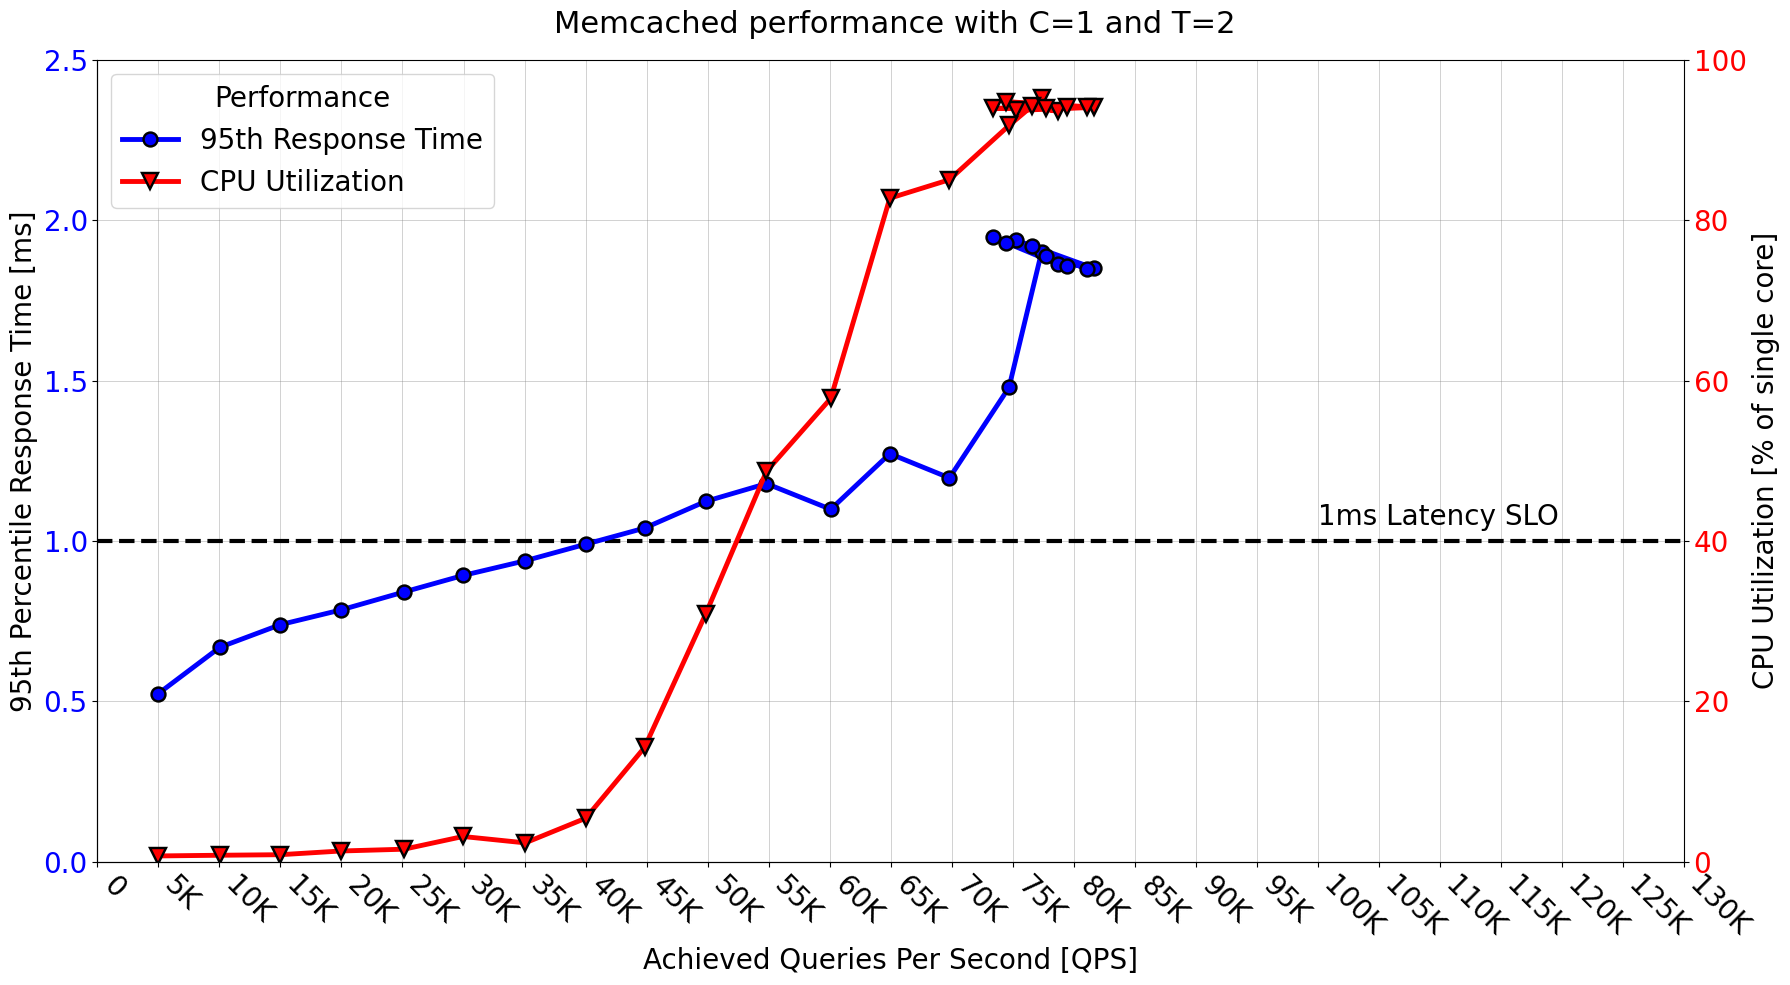

In [105]:
# Plot1
# data: key: C1, value: C1
fig, ax = plt.subplots(figsize=(18, 10))
ax2 = ax.twinx()
legend_dict = {'p95' : '95th Response Time', 'cpu' : 'CPU Utilization'}

slo_objective = ax.axhline(y=1, color='black', linestyle='--', linewidth=3)
ax.annotate('1ms Latency SLO', xy=(100000, 1.05), color='black', fontsize=20)
p95_line = ax.plot(merged_data['C1']['QPS'], merged_data['C1']['p95'], color='#0000ff', marker='o', 
        linewidth=3.5, markersize=10, markeredgewidth=1.75, markeredgecolor='black', label=legend_dict['p95'])[0]
cpu_line = ax2.plot(merged_data['C1']['QPS'], merged_data['C1']['C1'], color='#ff0000', marker='v',
         linewidth=3.5, markersize=12, markeredgewidth=1.75, markeredgecolor='black', label=legend_dict['cpu'])[0]

# Style
x_labels = ['0', '5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '45K', '50K', '55K', '60K',
            '65K', '70K', '75K', '80K', '85K', '90K', '95K', '100K', '105K', '110K', '115K', '120K', '125K', '130K']
ax.set_xticks(range(0, 131000, 5000), x_labels, rotation=-45, ha='left')
ax.set_xlabel('Achieved Queries Per Second [QPS]', fontsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.set_ylim((0, 2.5))
ax.set_yticks( np.arange(0, 2.6, 0.5).tolist())
ax.set_ylabel('95th Percentile Response Time [ms]', fontsize=20)
ax.tick_params(axis='y', labelcolor='blue', labelsize=20)

ax2.set_ylim((0, 100))
ax2.set_yticks( np.arange(0, 101, 20).tolist())
ax2.set_ylabel('CPU Utilization [% of single core]', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)

lines = [p95_line, cpu_line]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, title='Performance', loc='upper left', title_fontsize=20, fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linewidth=0.5, alpha=0.5)
fig.suptitle('Memcached performance with C=1 and T=2', fontsize=22)
#ax.set_title('(3 runs)', fontsize=20)
fig.tight_layout()

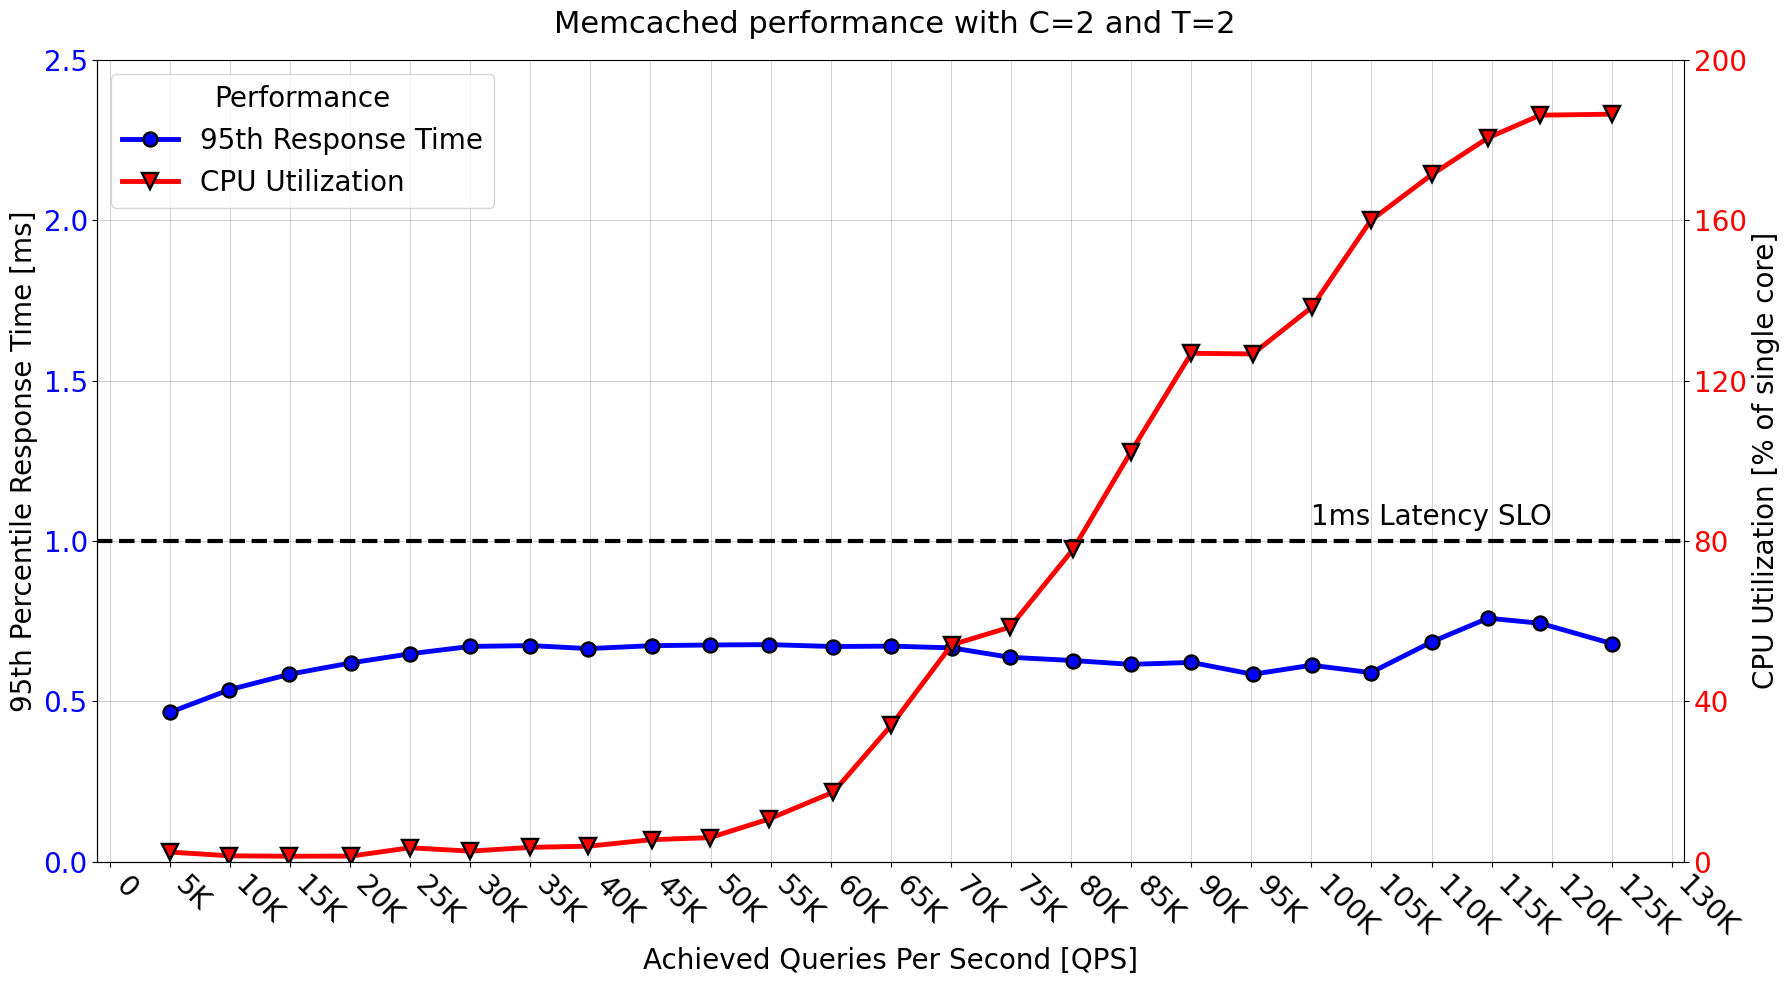

In [106]:
# Plot2
# data: key: C2, value: C1+C2
fig, ax = plt.subplots(figsize=(18, 10))
ax2 = ax.twinx()
legend_dict = {'p95' : '95th Response Time', 'cpu' : 'CPU Utilization'}

slo_objective = ax.axhline(y=1, color='black', linestyle='--', linewidth=3)
ax.annotate('1ms Latency SLO', xy=(100000, 1.05), color='black', fontsize=20)
p95_line = ax.plot(merged_data['C2']['QPS'], merged_data['C2']['p95'], color='#0000ff', marker='o', 
        linewidth=3.5, markersize=10, markeredgewidth=1.75, markeredgecolor='black', label=legend_dict['p95'])[0]
cpu_line = ax2.plot(merged_data['C2']['QPS'], merged_data['C2']['C1'] + merged_data['C2']['C2'], color='#ff0000', marker='v',
         linewidth=3.5, markersize=12, markeredgewidth=1.75, markeredgecolor='black', label=legend_dict['cpu'])[0]

# Style
x_labels = ['0', '5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '45K', '50K', '55K', '60K',
            '65K', '70K', '75K', '80K', '85K', '90K', '95K', '100K', '105K', '110K', '115K', '120K', '125K', '130K']
ax.set_xticks(range(0, 131000, 5000), x_labels, rotation=-45, ha='left')
ax.set_xlabel('Achieved Queries Per Second [QPS]', fontsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.set_ylim((0, 2.5))
ax.set_yticks( np.arange(0, 2.6, 0.5).tolist())
ax.set_ylabel('95th Percentile Response Time [ms]', fontsize=20)
ax.tick_params(axis='y', labelcolor='blue', labelsize=20)

ax2.set_ylim((0, 200))
ax2.set_yticks(np.arange(0, 201, 40).tolist())
ax2.set_ylabel('CPU Utilization [% of single core]', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)

lines = [p95_line, cpu_line]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, title='Performance', loc='upper left', title_fontsize=20, fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linewidth=0.5, alpha=0.5)
fig.suptitle('Memcached performance with C=2 and T=2', fontsize=22)
#ax.set_title('(3 runs)', fontsize=20)
fig.tight_layout()